# Analyse des clusters d'accidents dans les villes

Ce notebook permet d'explorer les accidents au sein de certaines villes. L'objectif est de déceler des clusters d'accidents afin de cibler les lieux d'actions les plus pertinents afin d'agir sur les réglementation de circulation ou de modifier les infrastructures en place

In [1]:
#Importations

import matplotlib.pyplot as plt
import numpy as np
import math as mt

import pandas as pd

from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statistics import mean

import statsmodels.api as sm

from tqdm.notebook import tqdm

La cellule suivante permet de sélectionner les villes sur lesquelles effectuer le clustering : chaque ville porte un indice qui permet de repérer ses coordonnée grace à la liste coord. coord[Paris] par exemple permet de récuperer les coordonnées des sommets d'un rectangle dans lequel s'inscrit la ville de paris

In [2]:
#Indices des villes :
Paris=0
Lyon = 1 
Nice = 2
Toulouse = 3
Marseille = 4
coord=[[2.256,2.42,48.8,48.905],[4.766,4.933,45.6833,45.805],[7.2,7.283,43.66,43.73],[1.383,1.5,43.55,43.65],[5.3,5.43,43.23,43.34]]

ville=Paris

# Importation des données relatives à la ville sélectionnée

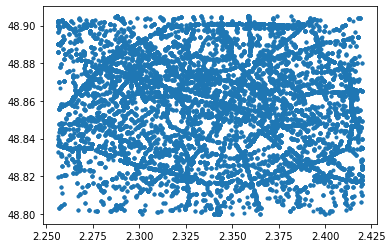

In [3]:
#Récupération des données brutes sous forme de data frame Pandas

dfCar = pd.read_csv('data/rawData-caracteristiques-2019.csv',sep=';')
dfLoc = pd.read_csv('data/rawData-lieux-2019.csv',sep=';')
dfUsr = pd.read_csv('data/rawData-usagers-2019.csv',sep=';')
dfVls = pd.read_csv('data/rawData-vehicules-2019.csv',sep=';')

## Fusion
df = pd.merge(dfCar,dfLoc,on="Num_Acc")
df = pd.merge(df,dfUsr,on="Num_Acc")
df = pd.merge(df,dfVls,on="Num_Acc")
X=[]
Y=[]
data=[]
indice=[]

def conversion_float(m):
    res=""
    for i in range(len(m)):
        if m[i]==',':
            res+="."
        else:
            res+=m[i]
    return res


for i in tqdm(range(len(df))):
    x=float(conversion_float(df['long'][i]))
    y=float(conversion_float(df['lat'][i]))
    if x>=coord[ville][0] and x<=coord[ville][1] and y >=coord[ville][2] and y<=coord[ville][3]:
        X.append(x)
        Y.append(y)
        indice.append(i)
        data.append([x,y])
        
#Visualisation graphique

plt.plot(X,Y,'.')
plt.show()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)

# Clustering : identification de zones à forte densité d'accidents

## 1. Avec K-means

Cette première section implémente l'algorithme k-means pour chercher les clusters d'accidents dans la ville sélectionnée. On utilise dans unpremier temps la méthode classique de la "recherche du coude"

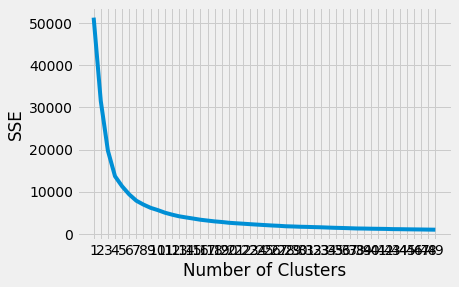

7

In [4]:
Nmax=50
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in tqdm(range(1, Nmax)):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, Nmax), sse)
plt.xticks(range(1, Nmax))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

kl = KneeLocator(
    range(1, Nmax), sse, curve="convex", direction="decreasing"
)
kl.elbow

Cette méthode ne semble pas très efficace puisqu'elle donne un nombre de clusters égal à 7 et assimile tout les points à un cluster ce qui conduit à des clusters de trop grande taille, reliant des zones d'accidents assez décorellées. On remarque aussi que cette méthode n'est pas très robuste car la zone de coude détectée semble fortement du nombre d'itérations considéré : la courbe SSE semble posséder, d'une certaine manière, une propriété d'invariance par changement d'échelle 

On utilise donc un nombre de clusters prédéfini à l'avance que l'on fixe dans un premier temps égal à 40

In [5]:
kmeans = KMeans(
    init="random",
    n_clusters=40,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans.fit(scaled_features)

centres=kmeans.cluster_centers_

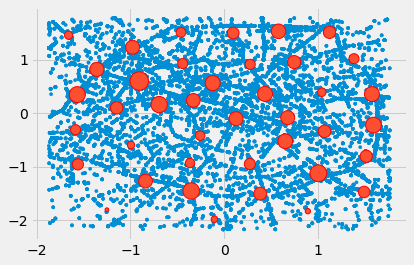

In [6]:
def taille_cluster(centre,dataset):
    compteur=0
    x0=centre[0]
    y0=centre[1]
    for i in range(len(dataset)):
        x=dataset[i][0]
        y=dataset[i][1]
        if mt.sqrt((x-x0)**2 + (y-y0)**2)<=0.13:
            compteur+=1
    return compteur
        

tailles_clusters=[]

for k in tqdm(range(len(centres))):
    tailles_clusters.append(taille_cluster(centres[k],scaled_features))

plt.scatter(scaled_features[:,0],scaled_features[:,1],s=[10 for i in range(len(scaled_features))])
plt.scatter(centres[:,0], centres[:,1],
               s = tailles_clusters,
               marker = 'o', edgecolors = 'red',facecolors=None,linewidth=1)

Dans la visualisation graphique ci-dessus, la taille des points est proportionnelle au nombre d'accidents.

## 2. Avec DBSCAN

Afin de dépasser le problème de la décision du nombre de clusters, il semble pertinent d'utiliser un algorithme qui décide lui même de ce cela. DBSCAN est une solution.

La cellule suivante permet d'utiliser cet algorithme

Estimated number of clusters: 146
Estimated number of noise points: 11973
Silhouette Coefficient: -0.138


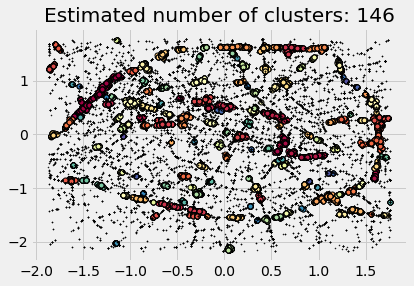

In [7]:
# Compute DBSCAN
db = DBSCAN(eps=0.05, min_samples=40).fit(scaled_features)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(scaled_features, labels))


# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = scaled_features[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy = scaled_features[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=0.5)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Une fois les clusters identifiés, nous utilisons une régression logistique pour identifier les caractéristiques communes aux zones accidentogènes

In [8]:
#permet d'étudier spécifiquement le cluster d'indice k (marqué en rouge sur la carte tacée)
nbVarRegr = 5
def etude_cluster(k, visualize = False):
    
    #Variables pour la regression
    
    #Variables explicatives
    inter=[]
    vma=[]
    catv=[]
    lum=[]
    manv=[]
    nbr_accidents=0
    
    #Variables à expliquer
    grav=[]
    
    #Pour le plot
    X=[]
    Y=[]
    
    for i in range(len(scaled_features)):
        if labels[i]==k:
            nbr_accidents+=1
            inter.append(df['int'][indice[i]])
            vma.append(df['vma'][indice[i]])
            catv.append(df['catv'][indice[i]])
            grav.append(df['grav'][indice[i]])
            lum.append(df['lum'][indice[i]])
            manv.append(df['manv'][indice[i]])
            X.append(scaled_features[i][0])
            Y.append(scaled_features[i][1])
    
    if visualize:
        plt.scatter(scaled_features[:,0],scaled_features[:,1],s=[10 for i in range(len(scaled_features))])
        plt.scatter(X, Y,s=[10 for i in range(len(X))],marker = 'o', edgecolors = 'red',facecolors=None,linewidth=1)
        plt.show()
    
    return lum,catv,manv,inter,vma,grav,nbr_accidents

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., 81.]),
 array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
        18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
        31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
        44., 45., 46., 47., 48., 49., 50.]),
 <a list of 45 Patch objects>)

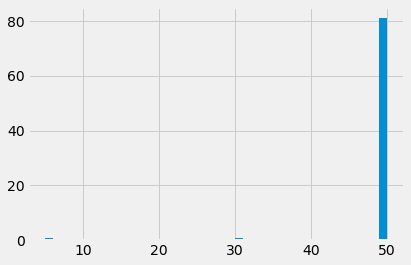

In [9]:
#Test 
lum,catv,manv,inter,vma,grav,nbr_accidents = etude_cluster(5)
l=vma
res=plt.hist(l, range = (min(l), max(l)), bins = max(l)-min(l))
res

In [10]:
equivalenceGravite = [0.0,0.3,0.8,1.0]

In [11]:
# Array numpy contenant les données par cluster
clusterData = np.zeros((n_clusters_,nbVarRegr+1))

for i in tqdm(range(n_clusters_)):
    clusterData[i,0] = i
    ti = etude_cluster(i)
    
    # Traitement de la gravité
    for j in range(len(ti[nbVarRegr])):
        ti[nbVarRegr][j] = equivalenceGravite[ti[nbVarRegr][j]-1]
    
    # Recherche du représentant majoritaire pour les variables catégorielles
    for j in range(nbVarRegr-1):
        ens=set(ti[j])
        compteurs=[0 for r in range(len(ens))]
        elements=[0 for r in range(len(ens))]
        for k,e in enumerate(ens):
            compteurs[k]=ti[j].count(e)
            elements[k]=e
        clusterData[i,j] = elements[compteurs.index(max(compteurs))]
    
    # Pour les variables non-catégorielles, on effectue une moyenne
    clusterData[i,nbVarRegr-1] = mean(ti[nbVarRegr-1]) #VMA
    clusterData[i,nbVarRegr] = mean(ti[nbVarRegr]) #Gravité

## **Régression logistique**

In [12]:
dfr = pd.DataFrame(clusterData, columns = ['lum','catv','manv','inter','vma','grav'])
print(dfr)

     lum  catv  manv  inter   vma      grav
0    1.0   7.0   1.0    1.0  59.0  0.449139
1    1.0   7.0   1.0    7.0  50.0  0.533333
2    1.0   7.0   1.0    2.0  47.0  0.506494
3    1.0   7.0   1.0    2.0  44.0  0.521910
4    1.0   7.0   3.0    1.0  69.0  0.387500
..   ...   ...   ...    ...   ...       ...
141  1.0   7.0   1.0    2.0  50.0  0.533333
142  5.0   7.0   2.0    1.0  50.0  0.580488
143  1.0  32.0  17.0    1.0  50.0  0.444444
144  5.0   7.0   2.0    1.0  62.0  0.358974
145  1.0   7.0   1.0    3.0  43.0  0.421277

[146 rows x 6 columns]


In [13]:
# Gestion des variables catégorielles
catg = ['lum','catv','manv','inter']

# Ondémultiplie chaque variable catégorielle en fonction du nombre de valeurs qu'elle prend
for var in catg:
    dummies = pd.get_dummies(dfr[var]).rename(columns=lambda x: var + '_' + str(x))
    dfr = pd.concat([dummies, dfr], axis=1)
    
print(dfr)

     inter_1.0  inter_2.0  inter_3.0  inter_4.0  inter_5.0  inter_7.0  \
0            1          0          0          0          0          0   
1            0          0          0          0          0          1   
2            0          1          0          0          0          0   
3            0          1          0          0          0          0   
4            1          0          0          0          0          0   
..         ...        ...        ...        ...        ...        ...   
141          0          1          0          0          0          0   
142          1          0          0          0          0          0   
143          1          0          0          0          0          0   
144          1          0          0          0          0          0   
145          0          0          1          0          0          0   

     manv_1.0  manv_2.0  manv_3.0  manv_15.0  ...  catv_32.0  lum_1.0  \
0           1         0         0          0  ... 

In [14]:
## Variables explicatives
exog = []
expl = catg + ['vma']
for var in dfr.columns:
    for varExpl in expl:
        if ((varExpl+'_') in var) or (varExpl==var and var not in catg):
            exog.append(var)

xtrain = dfr[exog]
xtrain = sm.add_constant(xtrain)

ytrain = dfr['grav']

In [16]:
lr = sm.Logit(endog=ytrain,exog=xtrain)
res = lr.fit_regularized()

print(res.summary())

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.6790327299050127
            Iterations: 1001
            Function evaluations: 10993
            Gradient evaluations: 1001
                           Logit Regression Results                           
Dep. Variable:                   grav   No. Observations:                  146
Model:                          Logit   Df Residuals:                      124
Method:                           MLE   Df Model:                           21
Date:                Wed, 19 May 2021   Pseudo R-squ.:              -0.0009095
Time:                        12:58:30   Log-Likelihood:                -99.139
converged:                      False   LL-Null:                       -99.049
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const

C:\Dossier Python\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Dossier Python\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Dossier Python\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Dossier Python\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Dossier Python\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
